In [62]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(1)

In [63]:
# Parameters
n_realizations = 2
N = 100 # number of observations
D = 400 
pstar = 20 # number of non-zero predictors
sigma = 1 # noise parameter

<h1> Generating Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [64]:
def generate_data(A, sigma):
  """
  Generate synthetic data.

  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real A: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  X = np.random.normal(size=(N, D)) # NxD
  beta_star = np.zeros([D]) # Initialise
  beta_star[:pstar] += A   # Add signal
  Y = jnp.dot(X, beta_star)
  print(Y.shape)
  Y += np.random.normal(0, sigma, size=N)  # Add noise
  return X, Y

generate_data(3,1)


(100,)


(array([[-0.04989146,  1.0142567 ,  0.06869922, ...,  0.54006551,
          0.05377848,  0.44731409],
        [ 0.41282435,  0.22128982,  1.72970843, ..., -0.68141272,
         -0.17469647, -1.68409296],
        [-1.58247109,  0.07217298, -0.52511112, ..., -0.56968743,
          0.40809721,  2.2012076 ],
        ...,
        [-0.86776811, -0.69343869,  1.10396905, ...,  1.91239408,
          0.69801635,  0.14880543],
        [ 0.48041727, -0.37279784, -1.10811943, ...,  1.5813026 ,
         -0.5068699 , -0.30251302],
        [-1.73064174, -0.3929614 , -0.60270863, ..., -0.29085954,
         -0.71027547,  0.26075634]]),
 Array([-22.94412   ,  11.845219  , -10.996491  ,  11.593957  ,
         -9.136577  ,   4.295266  ,  -0.63898754,  -4.026954  ,
         14.800452  ,  13.484817  ,   2.5504255 , -22.825373  ,
          0.30138624,  11.624318  , -12.2763815 ,   4.1155753 ,
         -3.0533748 , -12.963249  , -10.5416975 , -14.024772  ,
         -1.5564551 ,  -3.386362  ,  19.033022  ,  15

<h2> Defining the Model </h2>

$$\begin{align*} 
\gamma_i &= \sigma ((L_i + \log(\alpha_i)) / \lambda) \text{  for   } i = 1, ..., n \\
L_i &= \log (U_i) - \log (1-U_i)\\
U_i &\sim \text{Uniform}(0, 1)
\end{align*}$$




In order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$. Some choices for $\alpha_i$ could be $\sigma(y)$, $\exp (y)$, etc.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [65]:
def model(alphas, lam, X=None, Y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
    '''
    N, D = X.shape # NxD

    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) #Dx1
    
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) #Dx1

    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) #Dx1

    kappas = numpyro.deterministic("kappas", 1 - gammas) #Dx1

    betas = numpyro.sample("betas", dist.Normal(0, 1).expand([D])) #Dx1
    scaled_betas = gammas * betas #Dx1

    y_mean = jnp.dot(X, scaled_betas)

    y = numpyro.sample("Y", dist.Normal(y_mean, 0.1), obs=Y)
   
    

In [66]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [67]:
def concrete(all_data, lam):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11

    for A, data in all_data.items():
        X, Y = data

        beta_star = np.zeros(D) 
        beta_star[:pstar] += A

        alphas = jnp.ones(D)
        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)

        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        # mean_gammas = mean_gammas.mean(axis=0) # mean across all repetitions

        estimated_betas = mean_gammas * beta_star
        beta_samples[A] = estimated_betas 

        mean_sq_errors[A] = jnp.mean((estimated_betas - beta_star)**2)
        
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, mean_gammas, beta_samples, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [68]:
all_mse_values = dict()
mean_mse_values = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []

all_data = {}
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smaller_A_values = [4, 6]
for A in A_values:
    all_data[A] = generate_data(A=A, sigma=1) 

lams = [2, 1, 1/2, 1/100]

for lam in lams:
    mean_sq_errors, kappas, mean_gammas_lam, beta_samples, samples, mcmc = concrete(all_data, lam=lam)

    all_mse_values[lam] = []
    all_mse_values[lam].append(mean_sq_errors)
    all_mse_values[lam] = np.array(all_mse_values[lam])
    mean_mse_values[lam] = np.mean(all_mse_values[lam], axis=0)

    all_kappas[lam] = []
    all_kappas[lam].extend(kappas)

    mean_gammas[lam] = mean_gammas_lam

    mean_betas[lam] = beta_samples

    all_mcmc_runs.append(mcmc)


(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [69]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.99      0.01      1.00      0.99      1.00    934.23      1.00
      U[1]      0.96      0.06      0.98      0.90      1.00    953.21      1.00
      U[2]      0.99      0.01      1.00      0.99      1.00   1198.06      1.00
      U[3]      0.98      0.03      0.99      0.95      1.00    862.72      1.01
      U[4]      0.69      0.27      0.75      0.27      1.00    789.23      1.00
      U[5]      0.93      0.10      0.97      0.80      1.00    854.32      1.00
      U[6]      0.97      0.04      0.99      0.93      1.00   1096.15      1.00
      U[7]      0.97      0.05      0.99      0.92      1.00    968.07      1.00
      U[8]      0.98      0.03      0.99      0.95      1.00    809.49      1.00
      U[9]      0.94      0.09      0.97      0.85      1.00    983.74      1.00
     U[10]      0.94      0.09      0.97      0.84      1.00    837.86      1.00
     U[11]      0.96      0

<h1> Results </h1>

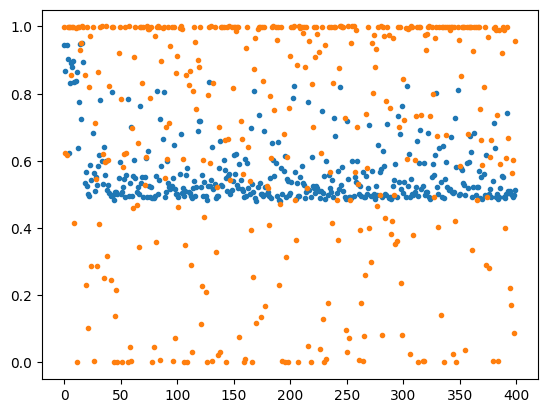

In [70]:
plt.plot(range(D), mean_gammas[2], '.')
plt.plot(range(D), mean_gammas[1/100], '.')

# for lam in [2, 1/100]:
#     ax.scatter(range(D), mean_gammas[lam], s=10, alpha = 0.5)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_89833/1782101894.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


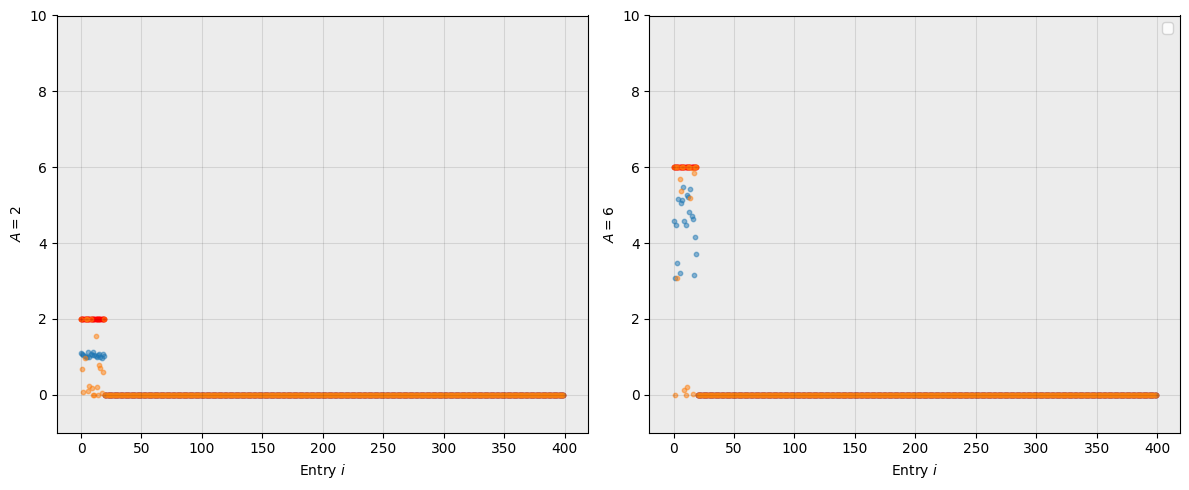

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="tight")
for ax in [ax1, ax2]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])

beta_star_6 = np.zeros(D)
beta_star_6[:pstar] = 6
beta_star_2 = np.zeros(D)
beta_star_2[:pstar] = 2

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax2.scatter(range(D), beta_star_6, color='red', s=10) 
for lam in [2, 1/100]:
    ax1.scatter(range(D), mean_betas[lam][2], s=10, alpha=0.5)
    ax2.scatter(range(D), mean_betas[lam][6], s=10, alpha=0.5)

# add labels to graph
ax1.set(ylabel=r'$A=2$', xlabel=r'Entry $i$')
ax2.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
plt.legend()


As $\lambda$ decreases, mean squared error decreases.

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

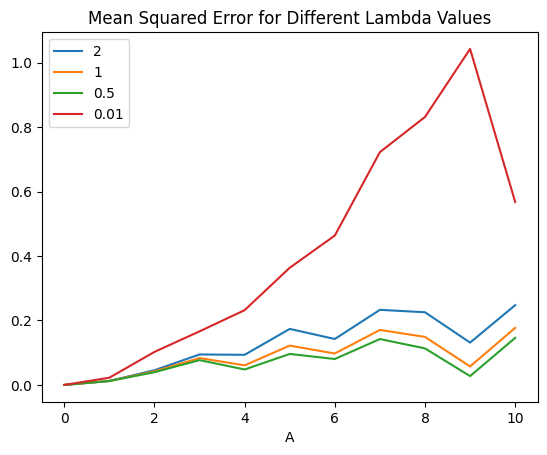

In [74]:
for lam in lams:
    plt.plot(range(len(mean_mse_values[lam])), mean_mse_values[lam], label=f'{lam}')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

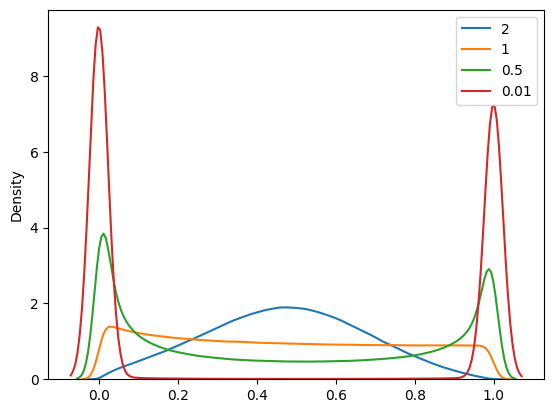

In [75]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()